<a href="https://colab.research.google.com/github/dl-ub-summer-school/2023/blob/main/DLUB_Transformers_s1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Colab credits and sources

---


- Objective: Implement Transformer architecture from scratch

- Approach: Down to Top

- Colab credit goes to: https://github.com/enod-bataa/scaling-telegram.git
- Visuals credits goes to : https://www.youtube.com/watch?v=dichIcUZfOw&t=635s

#Transformer Overview

##Transformer architecture

![ alt Transformers](https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png)





##Translation Inference

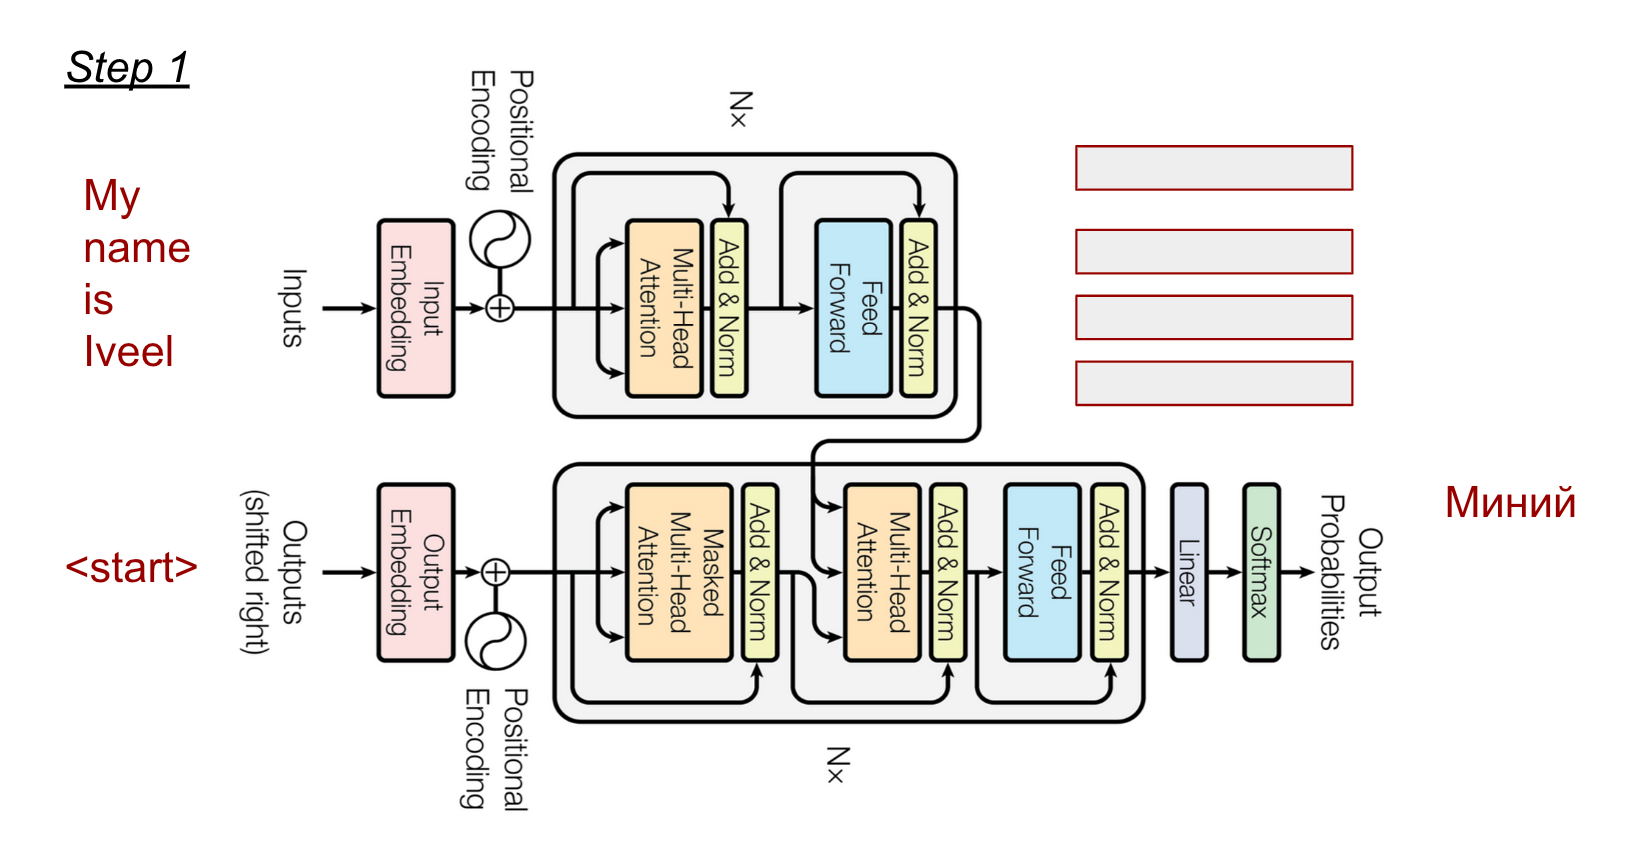

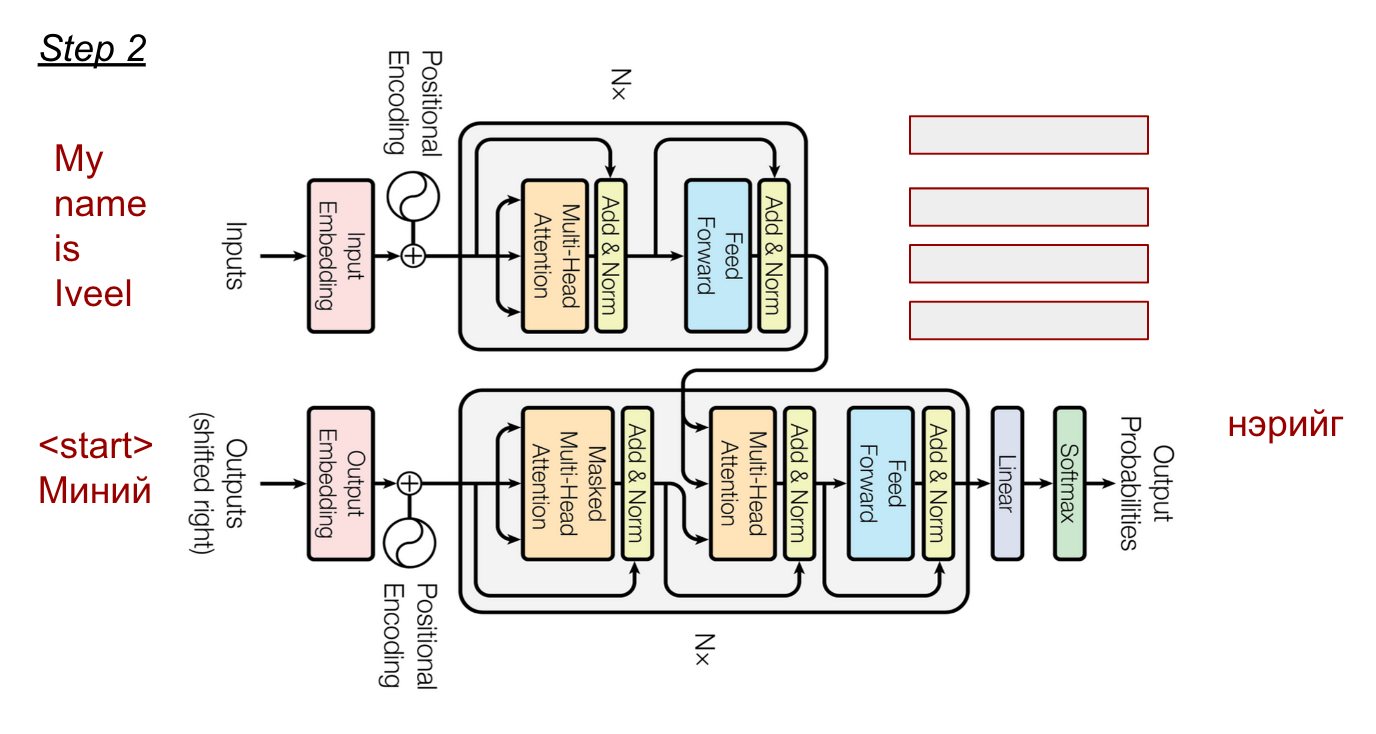

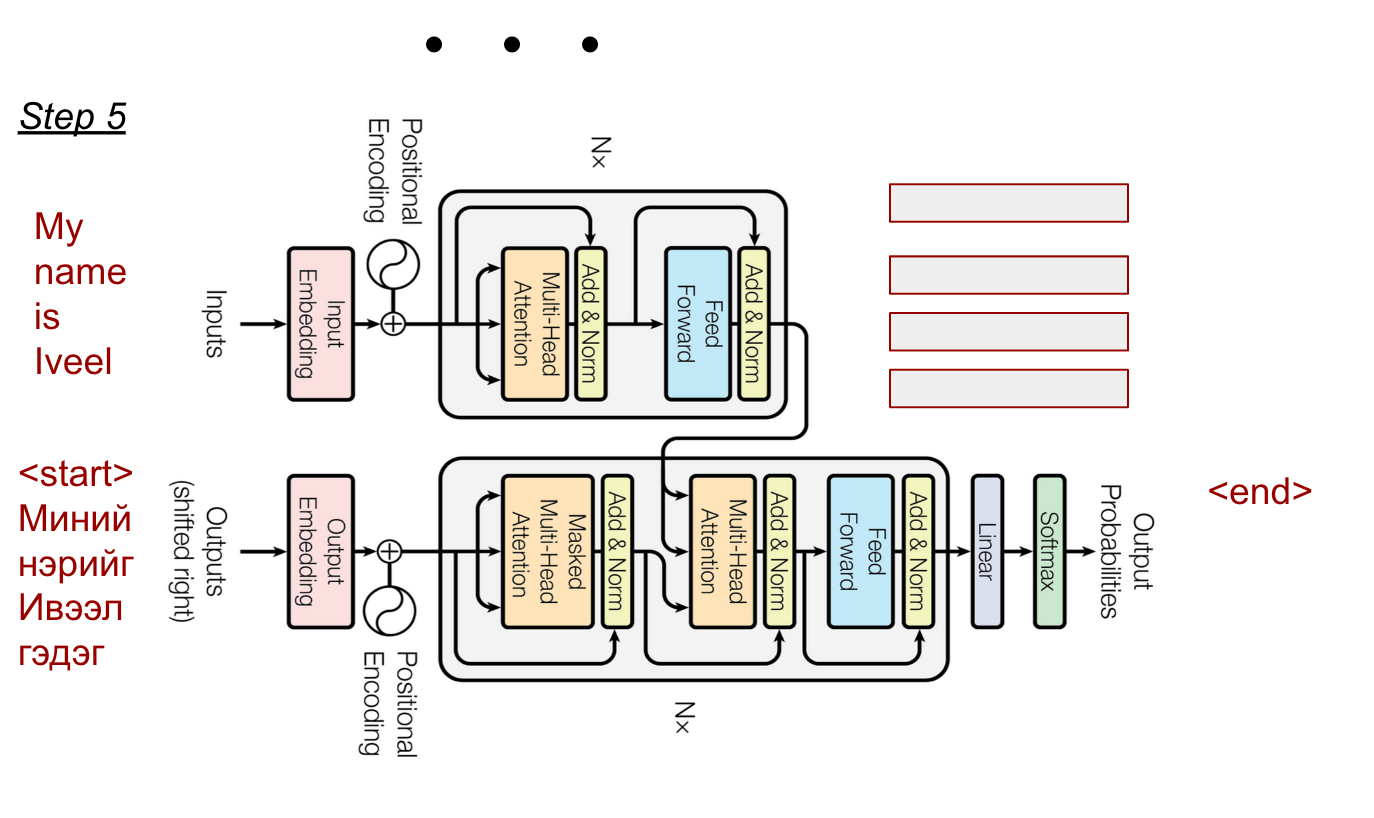

##Attention in Tranformers

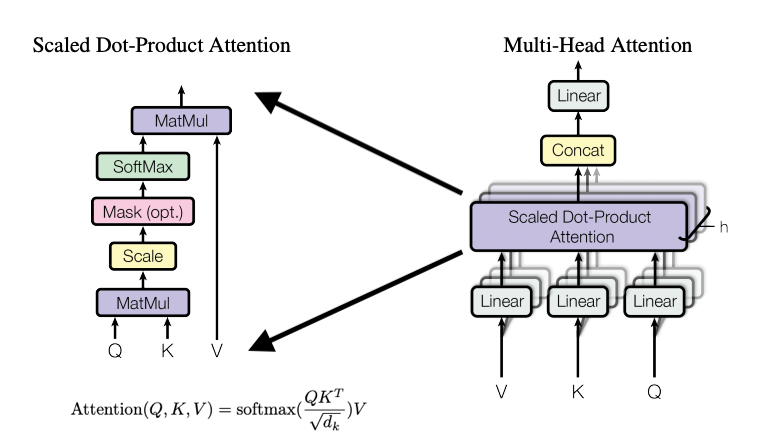

* Q: What I look for
* K: What I can offer
* V: What I actually offer

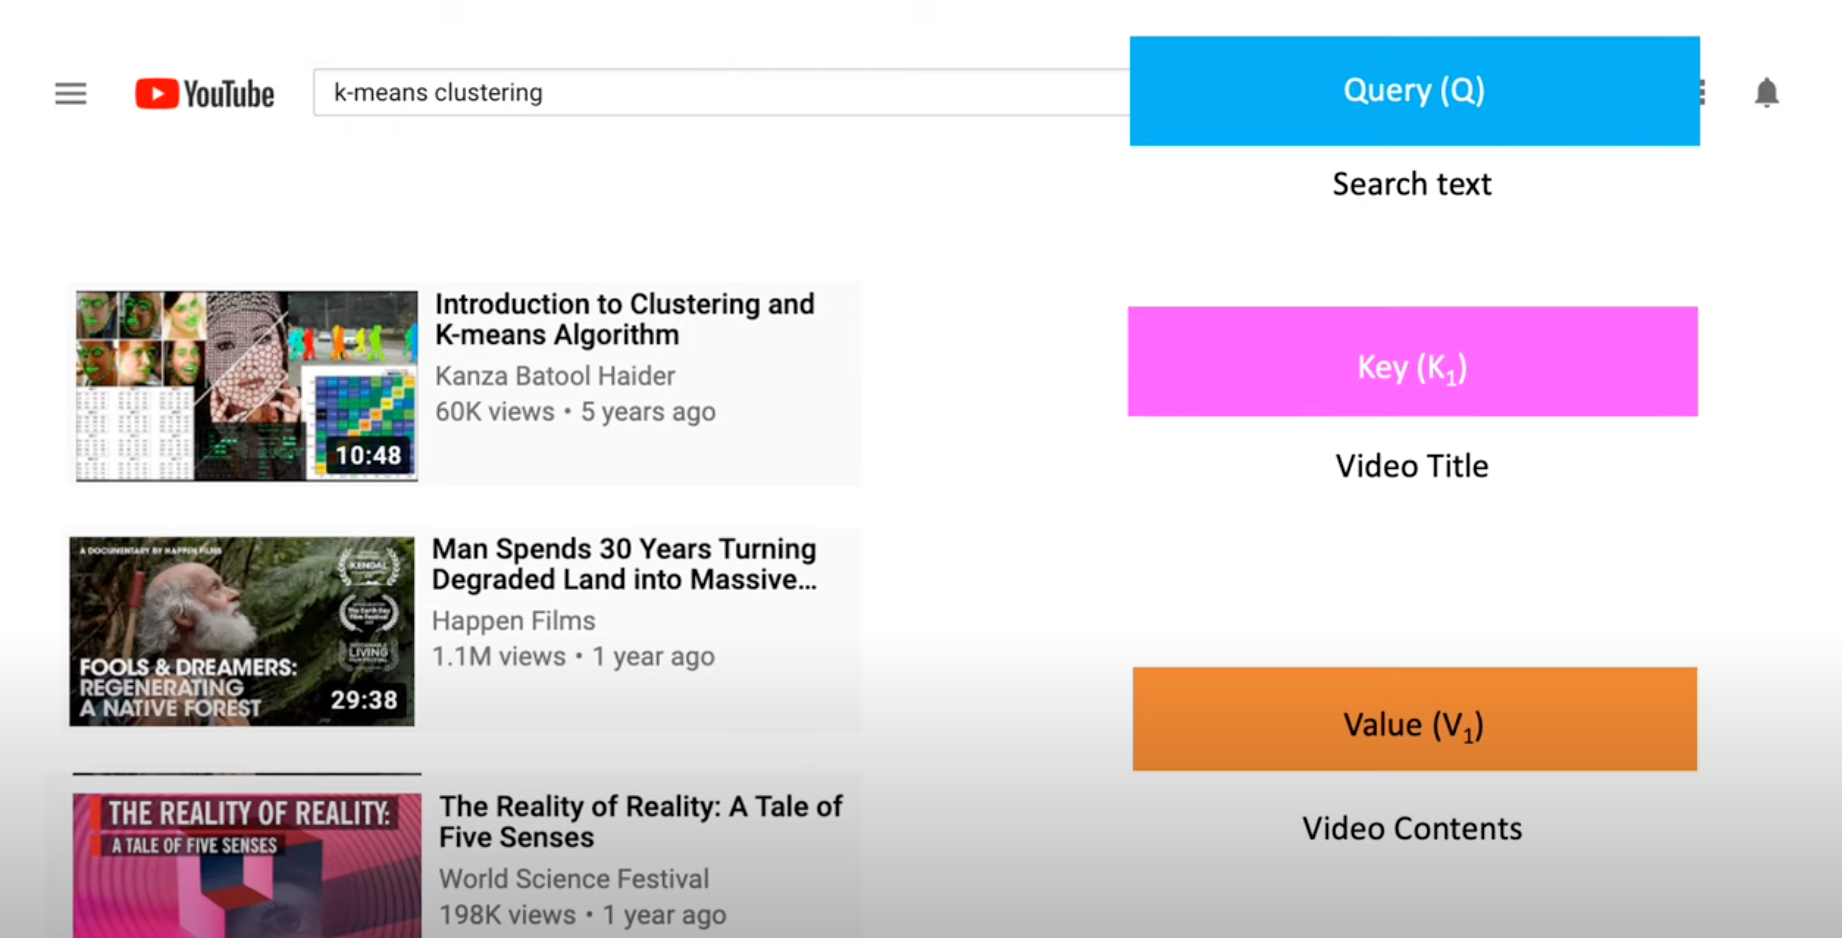

# Setup

In [ ]:
!git clone https://github.com/enod-bataa/scaling-telegram.git

In [ ]:
import os
os.listdir('./')

In [ ]:
os.chdir('scaling-telegram/src')

In [ ]:
import torch
import torch.nn as nn
import math
import utils
import dataloader
from torch.utils.data import DataLoader
from torch.optim import Adam

In [ ]:
# Below all hyper parameters assigned for the
# convenience of notebook, however, it is not a best practice
# as you should probably want to use hydra or argparse instead
gpu_id=0
seed=42
save=0

device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else 'cpu')
print(device)

num_enc_layers=6
num_dec_layers=6
max_len= 20
model_dim=512
hidden_size=2048
d_k=64 # =model_dim/n_head
d_v=64
n_head=8 # Parallel computation
d_prob=0.1 # Probability to turn off -> better generalization
max_norm=5.0

# attention is all you need hyper-params
n_epochs=100
batch_size=30 # Multiple examples to pass -> faster and stable training
lr=1e-3
beta1=0.9
beta2=0.98
eps=1e-9
weight_decay=1e-3
# bluescore
k=4

cuda:0


# Implementing Transformer from scratch

## 1. Embeddings and Positional embedding

### 1.1 Input processing

First we create a dictionary for all the words we have with corresponding indexes. And this dictionary will be used as a lookup table for converting text into a series of numbers.

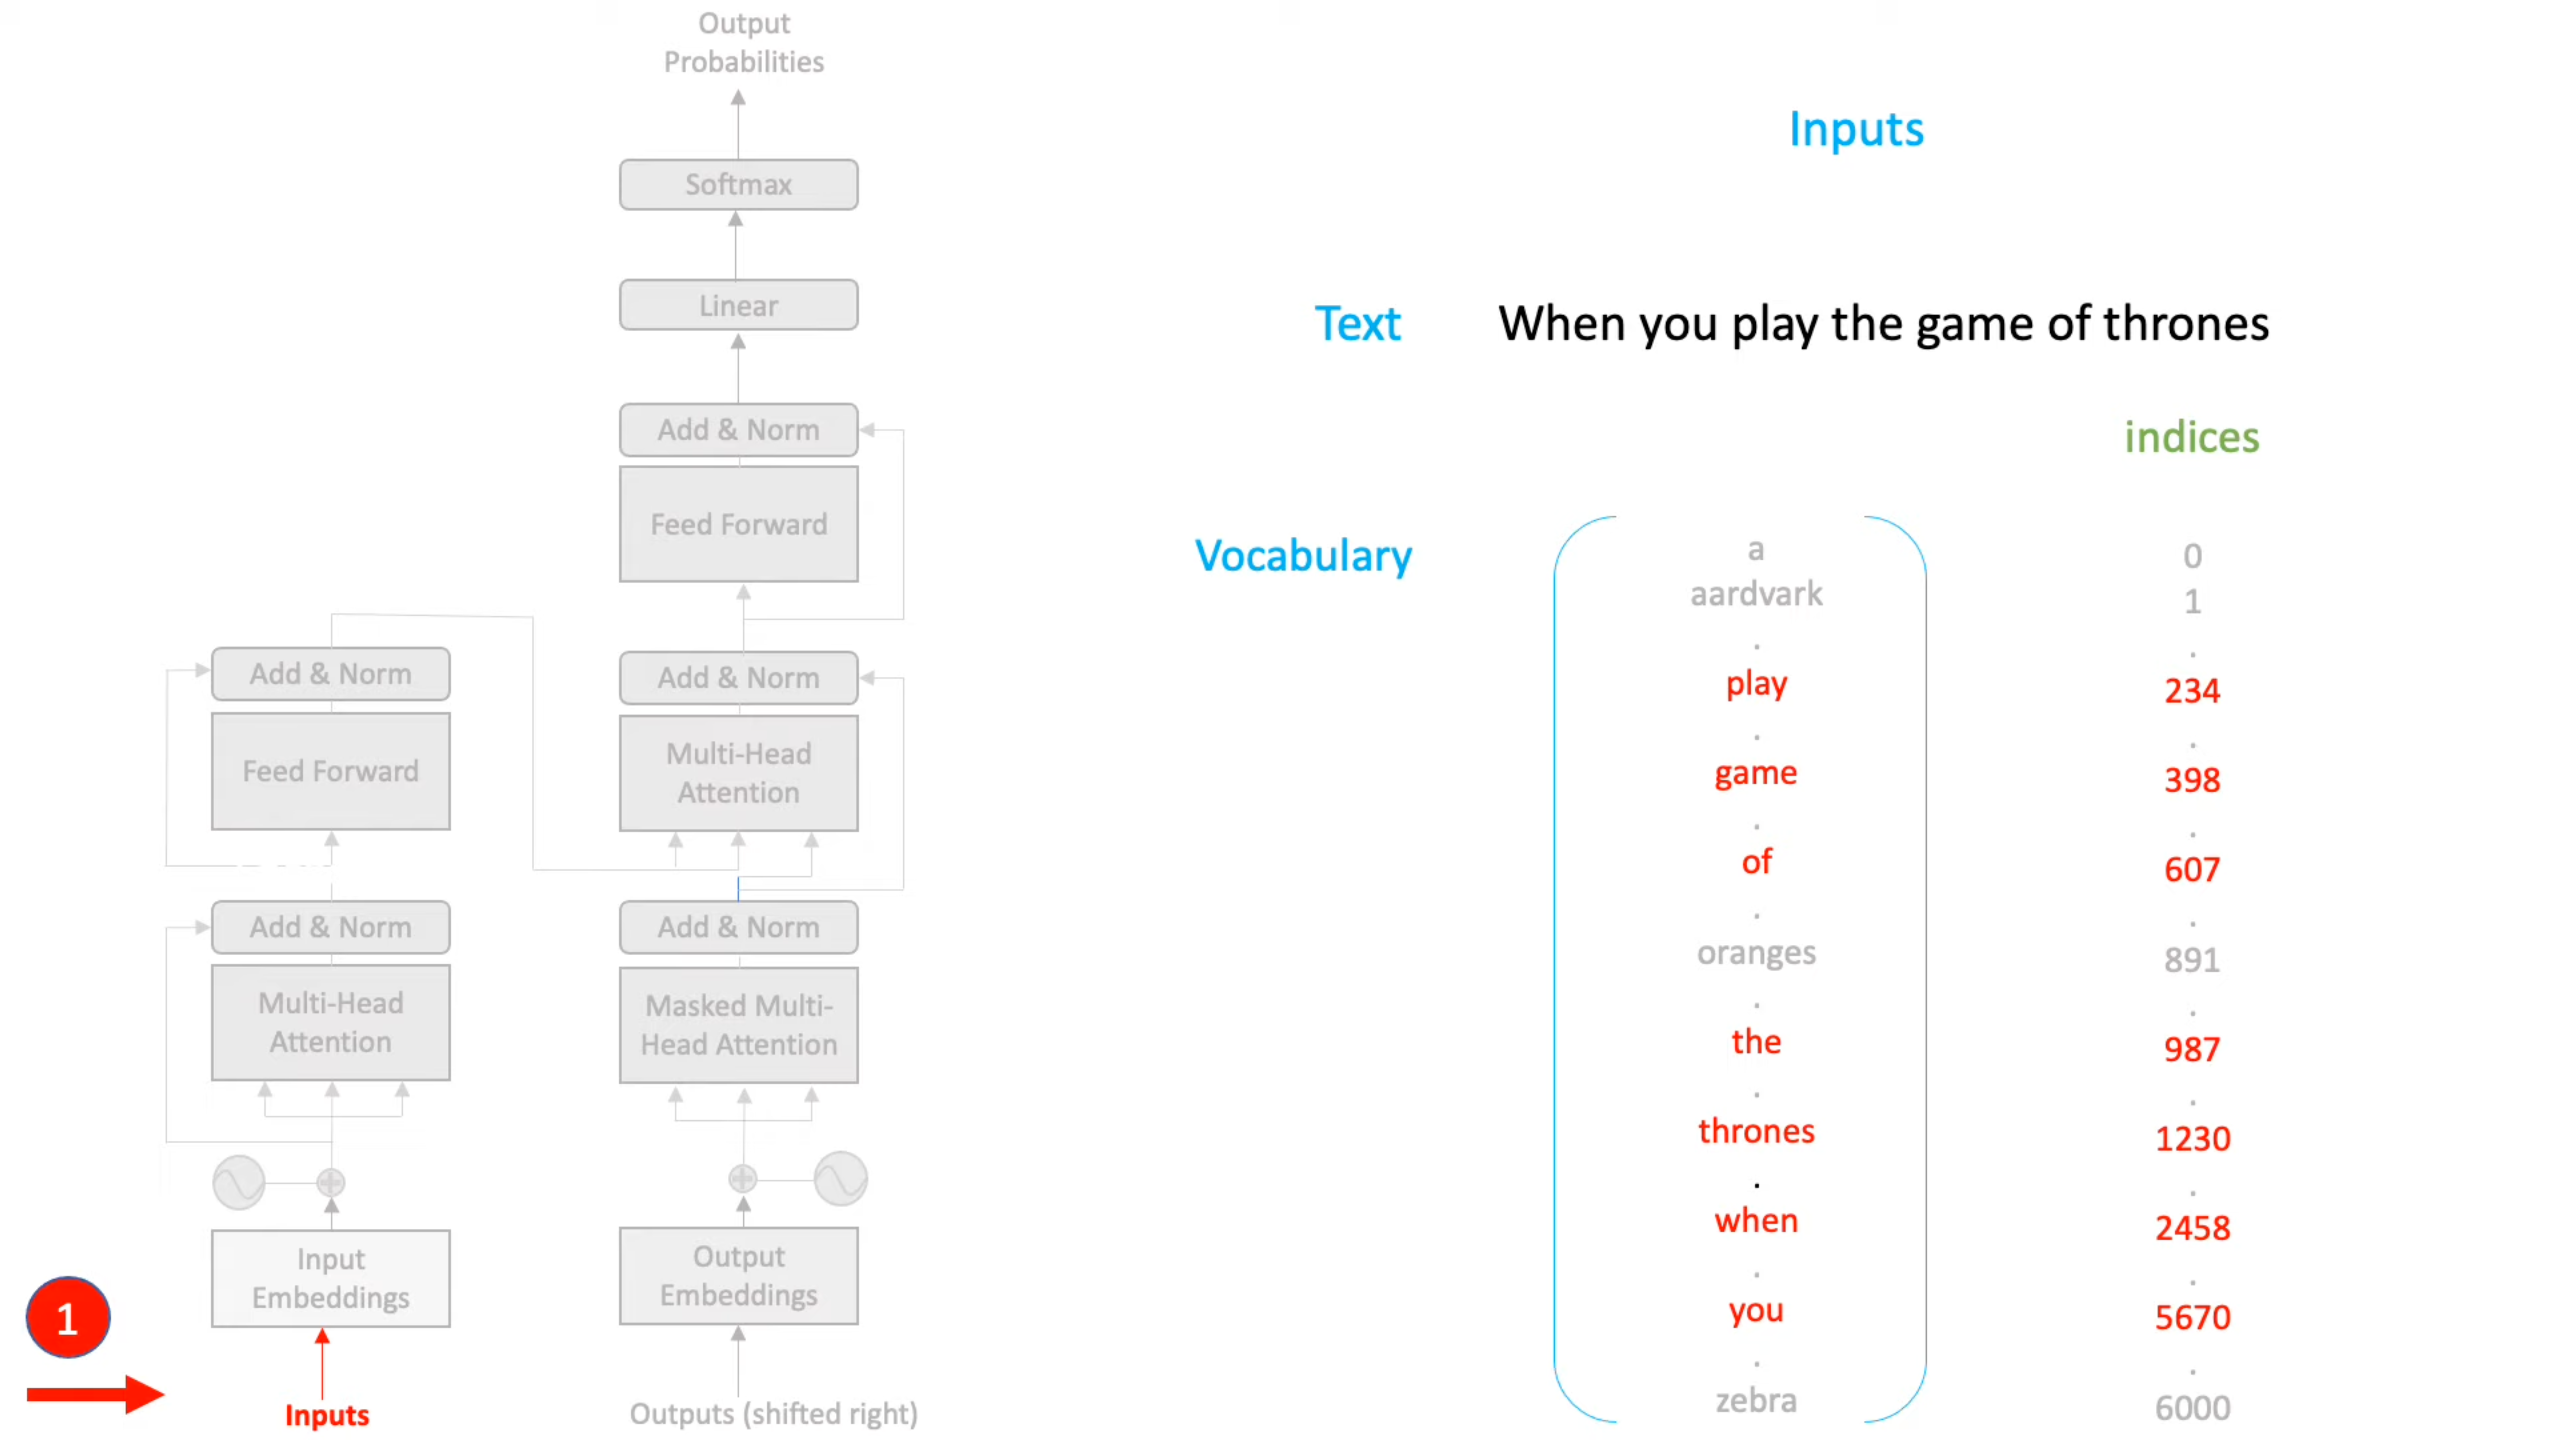

---



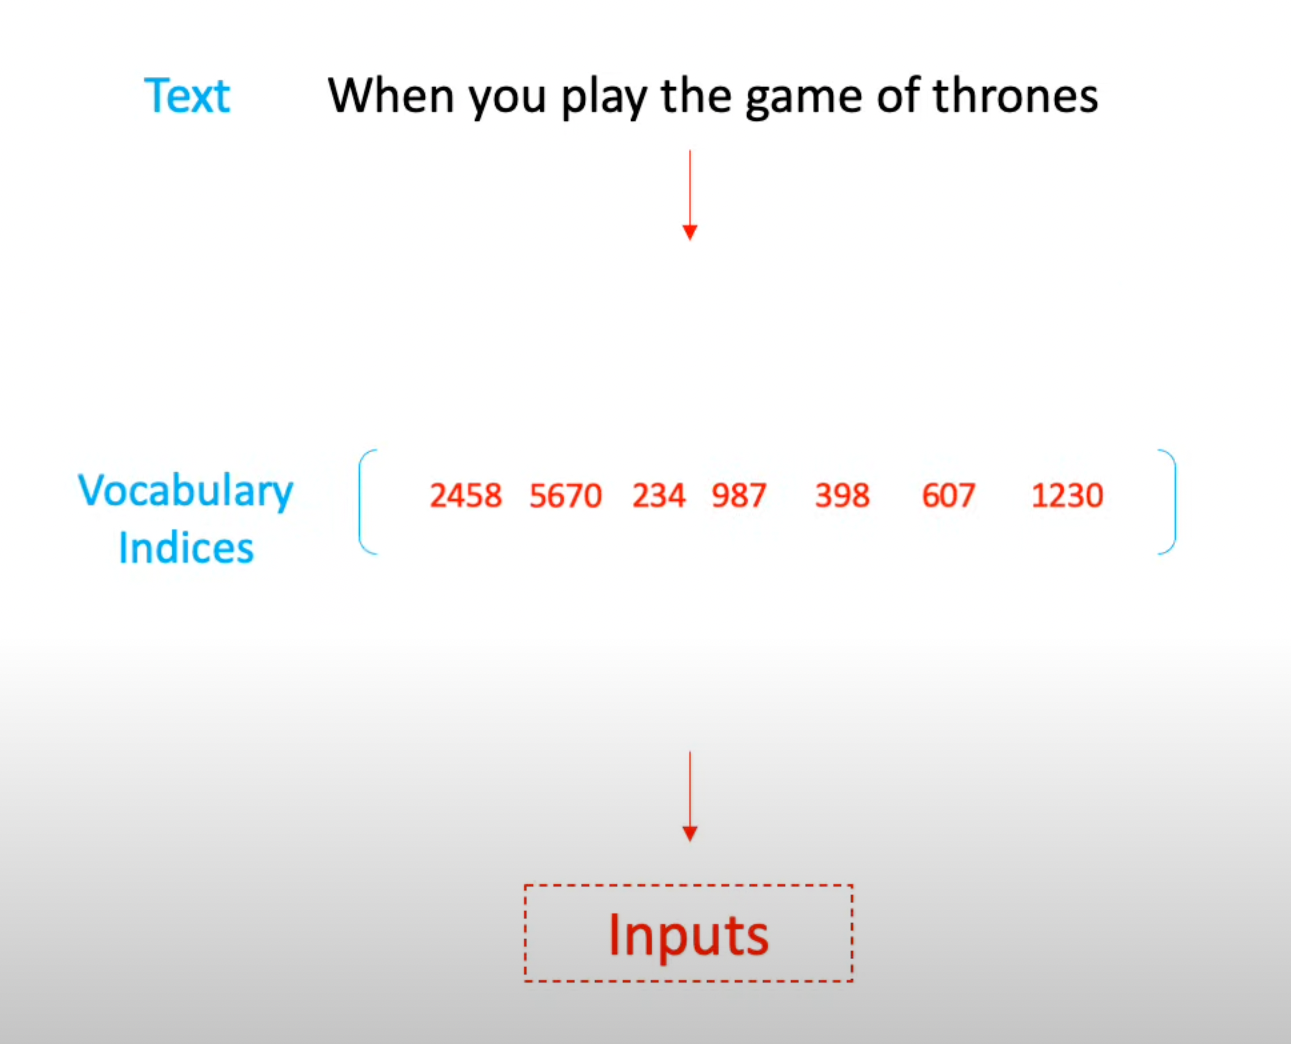

dataloader and dataset_prep.py contents

### 1.2 Embedding layer

Once we are done with above, then we need to pass the numeric representation into an embedding layer. But what is an embedding? Embedding is simply a vector representation of words. It is first initialised with random number and during the training process, it will be learnt so that similar words in the context will be close in the vector space - hence understands the meanining at some level.

Embeddings on the input, however, doesn't have information of word orders. That's when Positional embeddings comes to the rescue.

Suppose we have following 2 sentences:

1. Even though she did not win the award, she was satisfied.
2. Even though she did win the award, she was not satisfied

If we look at the words, it is exactly the same however, only the location of the word `not` is different - therefore changes the meaning completely. Position embeddings brings the order to the word.

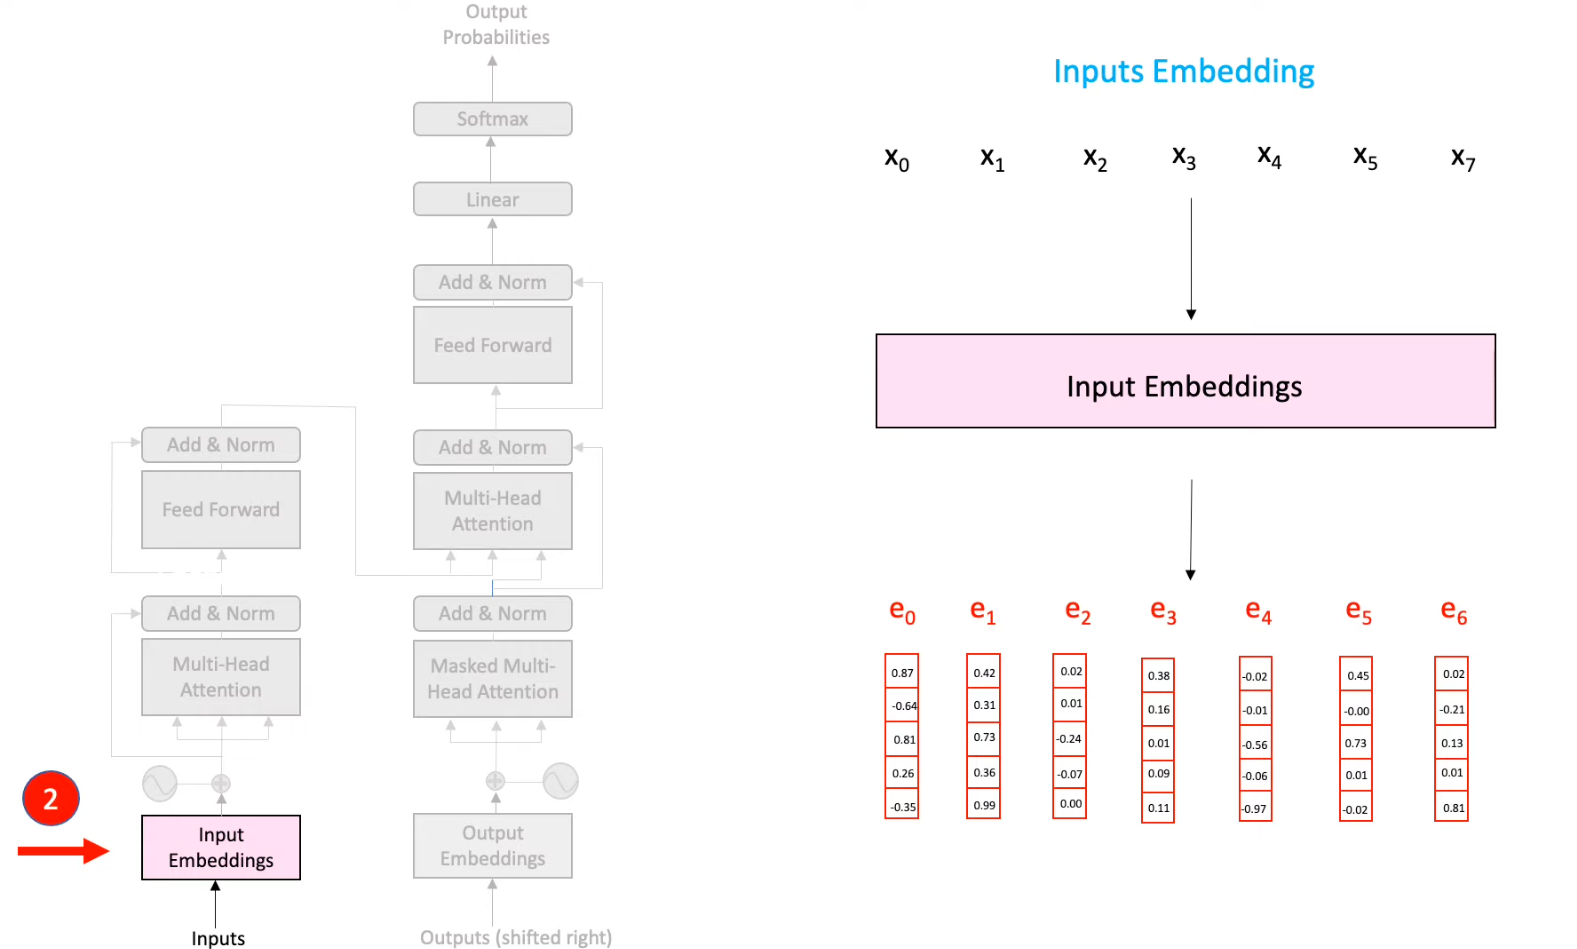

### 1.3 Positional Embedding

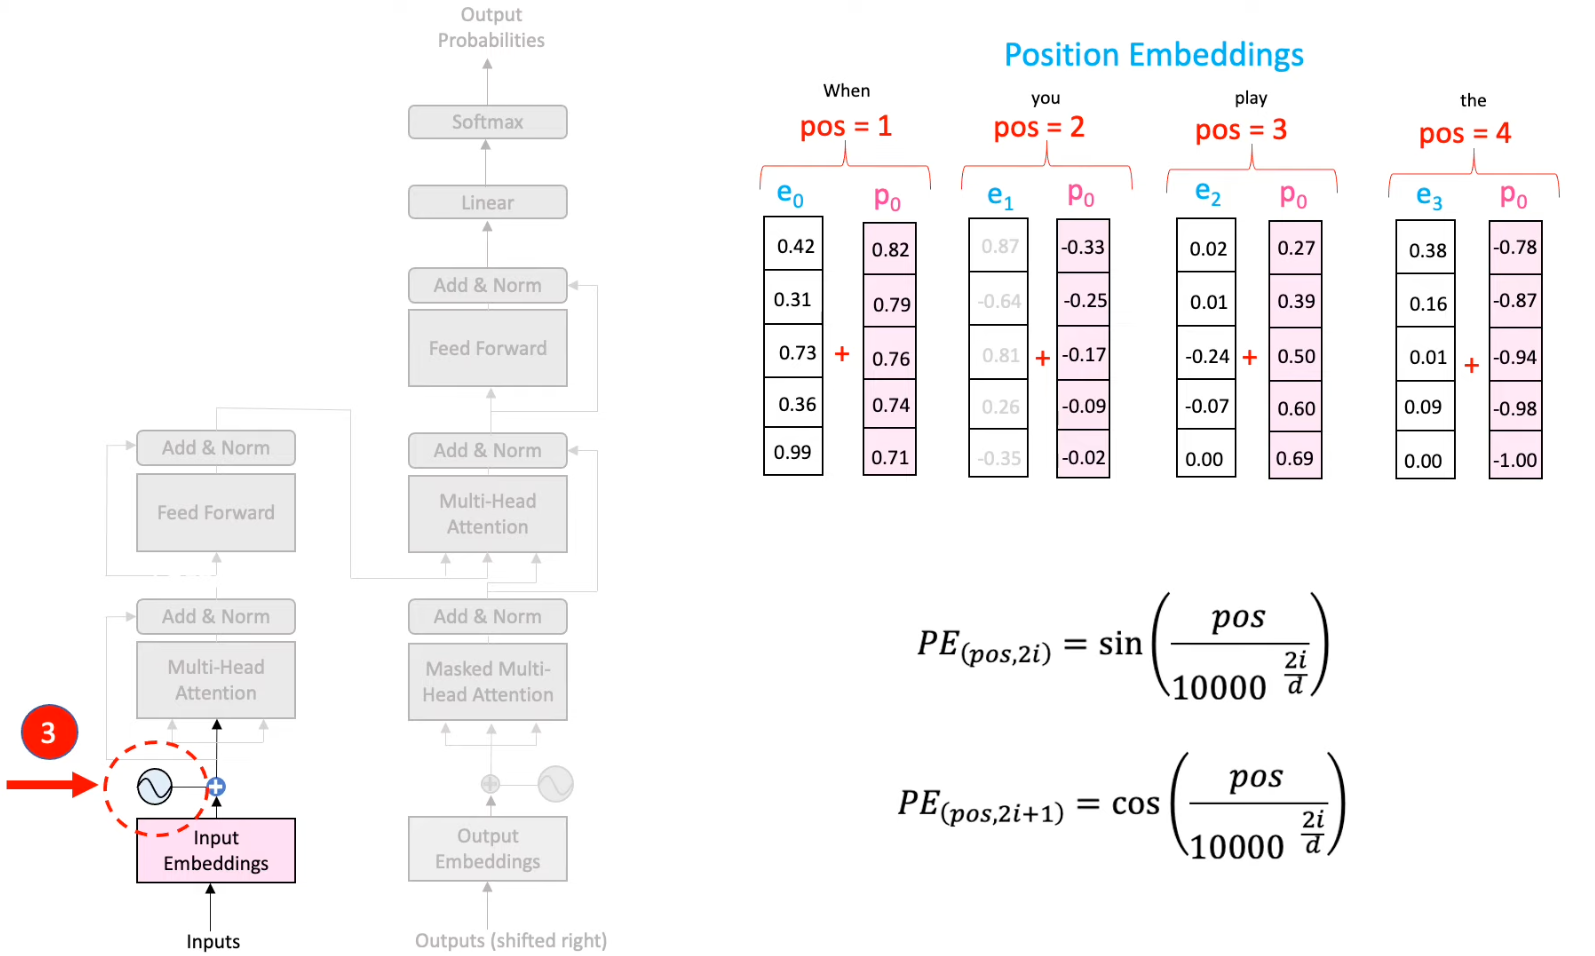

### 1.4 Implementation

In [ ]:
# Define the embedding layer with 10 vocab size and 3 vector embeddings.
# PyTorch created a lookup table called embedding. This table has 10 rows and 3 columns
embedding = nn.Embedding(10, 3, padding_idx=0)
input = torch.LongTensor([[1, 2, 1, 5]])
print(input)
# Expressed each input as a vector size of 3.
embedding(input)

In [ ]:
class Embedding_Layer(nn.Module):

    def __init__(self, num_token, dim_model, max_seq_len, d_prob):
        """Implementation of embedding and positional embeddings.

        Args:
            num_token (int): Number of token
            dim_model (_type_): Dimension of the model
            max_seq_len (_type_): Maximum sequence length
            d_prob (_type_): Dropout probability
        """
        super(Embedding_Layer, self).__init__()
        self.num_token = num_token
        self.dim_model = dim_model
        self.max_seq_len = max_seq_len
        self.d_prob = d_prob
        self.emb = nn.Embedding(num_token, dim_model)
        self.drop_out = nn.Dropout(d_prob)
        self.pos_enc = torch.zeros((self.max_seq_len, self.dim_model))
        for pos in range(self.max_seq_len):
            for idx in range(0, self.dim_model, 2):
                self.pos_enc[pos, idx] = torch.sin(torch.tensor(pos / (10000.0) ** (float(idx) / self.dim_model)))
                self.pos_enc[pos, idx + 1] = torch.cos(torch.tensor(pos / (10000.0) ** (float(idx) / self.dim_model)))

    def forward(self, x, pos=None):
        # To be implemented
        x = self.emb(x)
        x += self.pos_enc.cuda()
        return self.drop_out(x)

In [ ]:
# ### Test it out
emb_test = Embedding_Layer(10, 2, 4, 0.1) # 10 token, 2 dim, 4 max_seq, 0.1
input_test = torch.LongTensor([[1,2,4,5],[4,3,2,9]]) # A batch of 2 samples
emb_test(input_test)

## 2. Transformer Encoder

### 2.1 Scaled Dot-Product Attention

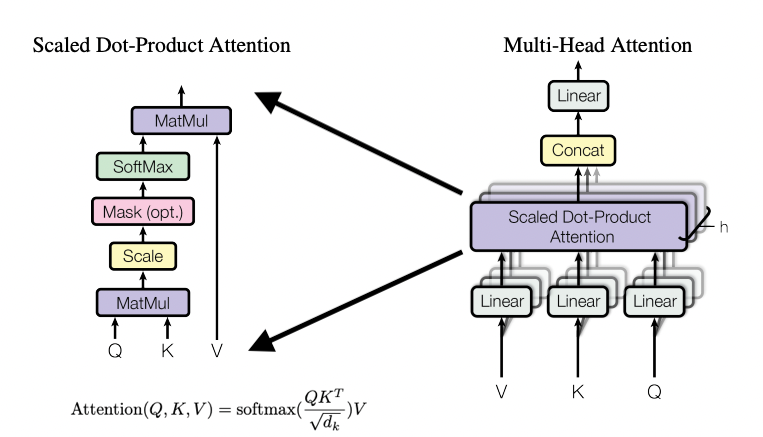

In [ ]:
# Batch, sequence len, embedding dim
x = torch.Tensor(30, 200, 512)
x.size(), x.T.size(), x.transpose(-1,-2).size()

In [ ]:
# Masking
x = torch.Tensor(3, 3)
print(x)
mask = torch.Tensor([
    [True, False, False],
    [True, True, False],
    [True, True, True]])

x.masked_fill(mask==False, 999)

In [ ]:
# One attention head
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, d_prob):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        self.softmax = nn.Softmax(dim=-1)
        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x_q, x_k, x_v, pad_mask):
        # To be implemented
        pass

### 2.2 Multi-Head Attention

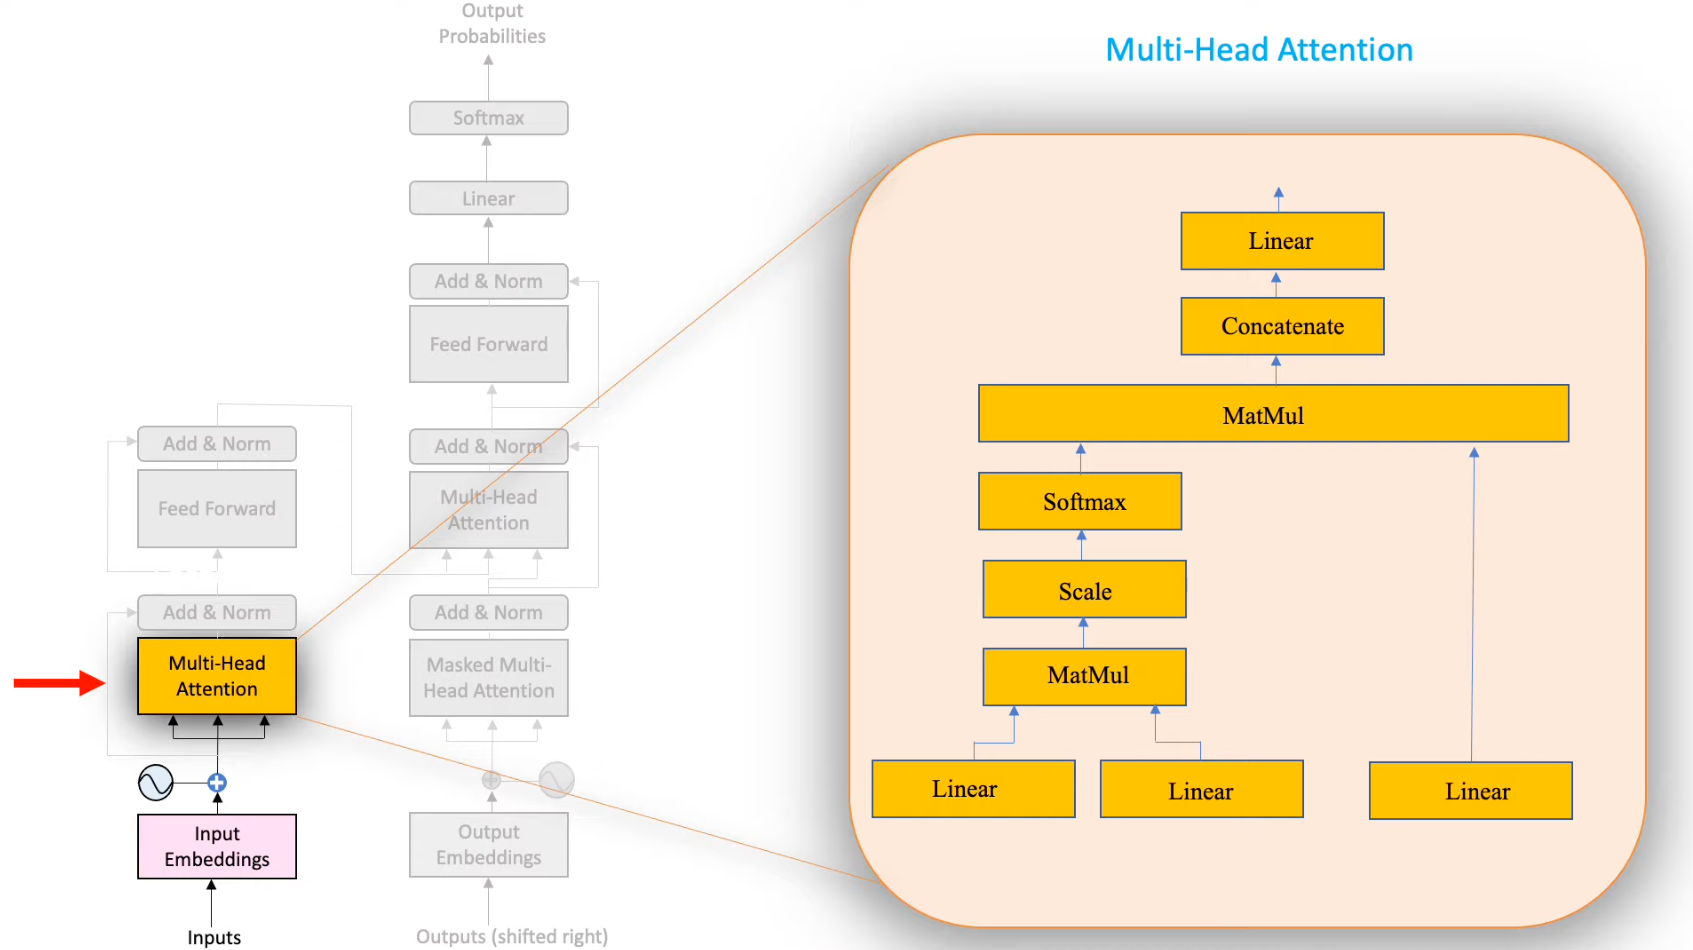

In [ ]:
# Model example
l = nn.Linear(3,3)
print(l)
t = torch.Tensor(4, 3)
t

In [ ]:
# [batch_size, seq_len, 512] -> [batch_size, att_head, seq_len, att_dim]
x = torch.Tensor(30, 200, 512)
print(x.view(30, -1, 8, 64).size())
x.view(30, -1, 8, 64).transpose(1,2).size()

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, d_prob):
        super(MultiHeadAttention, self).__init__()

        self.dim_model = dim_model # 512
        self.d_k = d_k # 64
        self.d_v = d_v #64
        self.n_head = n_head # 8

        self.qkv_layer = nn.Linear(dim_model,  3 * dim_model) # 512 x 1536
        self.linear_layer = nn.Linear(dim_model, dim_model) # 512 x 512

        self.w_q = nn.Linear(dim_model, dim_model)
        self.w_k = nn.Linear(dim_model, dim_model)
        self.w_v = nn.Linear(dim_model, dim_model)
        self.w_o = nn.Linear(dim_model, dim_model)

        self.scaled_dot_prod = ScaledDotProductAttention(d_k, d_prob)

    def forward(self, q, k, v, pad_mask):
        # To be implemented
        pass

In [ ]:
# # Test it out
# multi_ha = MultiHeadAttention(512, 64, 64, 8, 0.1)
# x = torch.Tensor(30, 200, 512)
# multi_ha(x, x, x, pad_mask=x)

### 2.3 Feed Forward

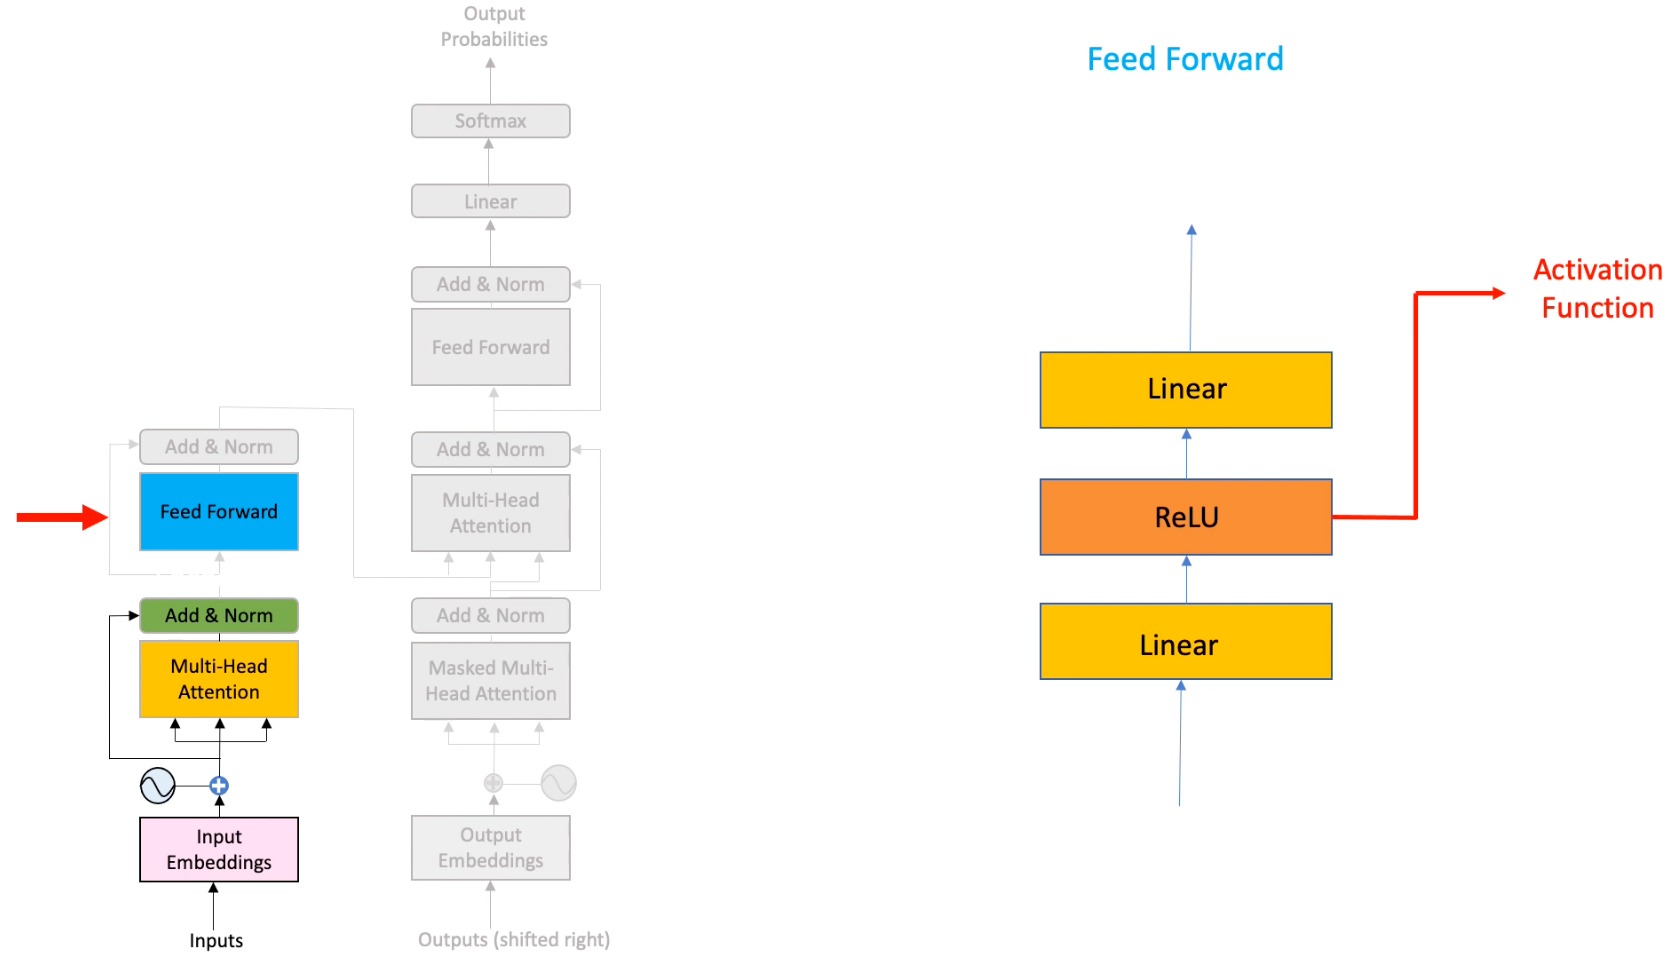

In [ ]:
class FFNN(nn.Module):
    def __init__(self, dim_model, dim_hidden, d_prob):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(dim_model, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_model)

        self.relu = nn.ReLU()
        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x):
        output = self.fc2(self.drop_out(self.relu(self.fc1(x))))
        return output, x

### 2.4 Encoder layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob):
        super(EncoderLayer, self).__init__()
        self.dim_model = dim_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_head = n_head
        self.dim_hidden = dim_hidden
        self.d_prob = d_prob

        self.multi_head_attn = MultiHeadAttention(dim_model, d_k, d_v, n_head, d_prob)
        self.ffnn = FFNN(dim_model, dim_hidden, d_prob)

        self.layer_norm1 = nn.LayerNorm(dim_model)
        self.layer_norm2 = nn.LayerNorm(dim_model)

        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x, src_pad_mask):
        # To be implemented
        pass

### 2.5 Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_enc_layer):
        super(Encoder, self).__init__()
        self.dim_model = dim_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_head = n_head
        self.dim_hidden = dim_hidden
        self.d_prob = d_prob
        self.n_enc_layer = n_enc_layer

        self.enc_layers = nn.ModuleList([EncoderLayer(dim_model, d_k, d_v, n_head, dim_hidden, d_prob) for _ in range(n_enc_layer)])

    def forward(self, x, src_pad_mask):
        # To be implemented
        pass

## 3. Transformer Decoder

Decoder is basically the same as Encoder implementation. However, there are only a few pieces that are different as shown below:

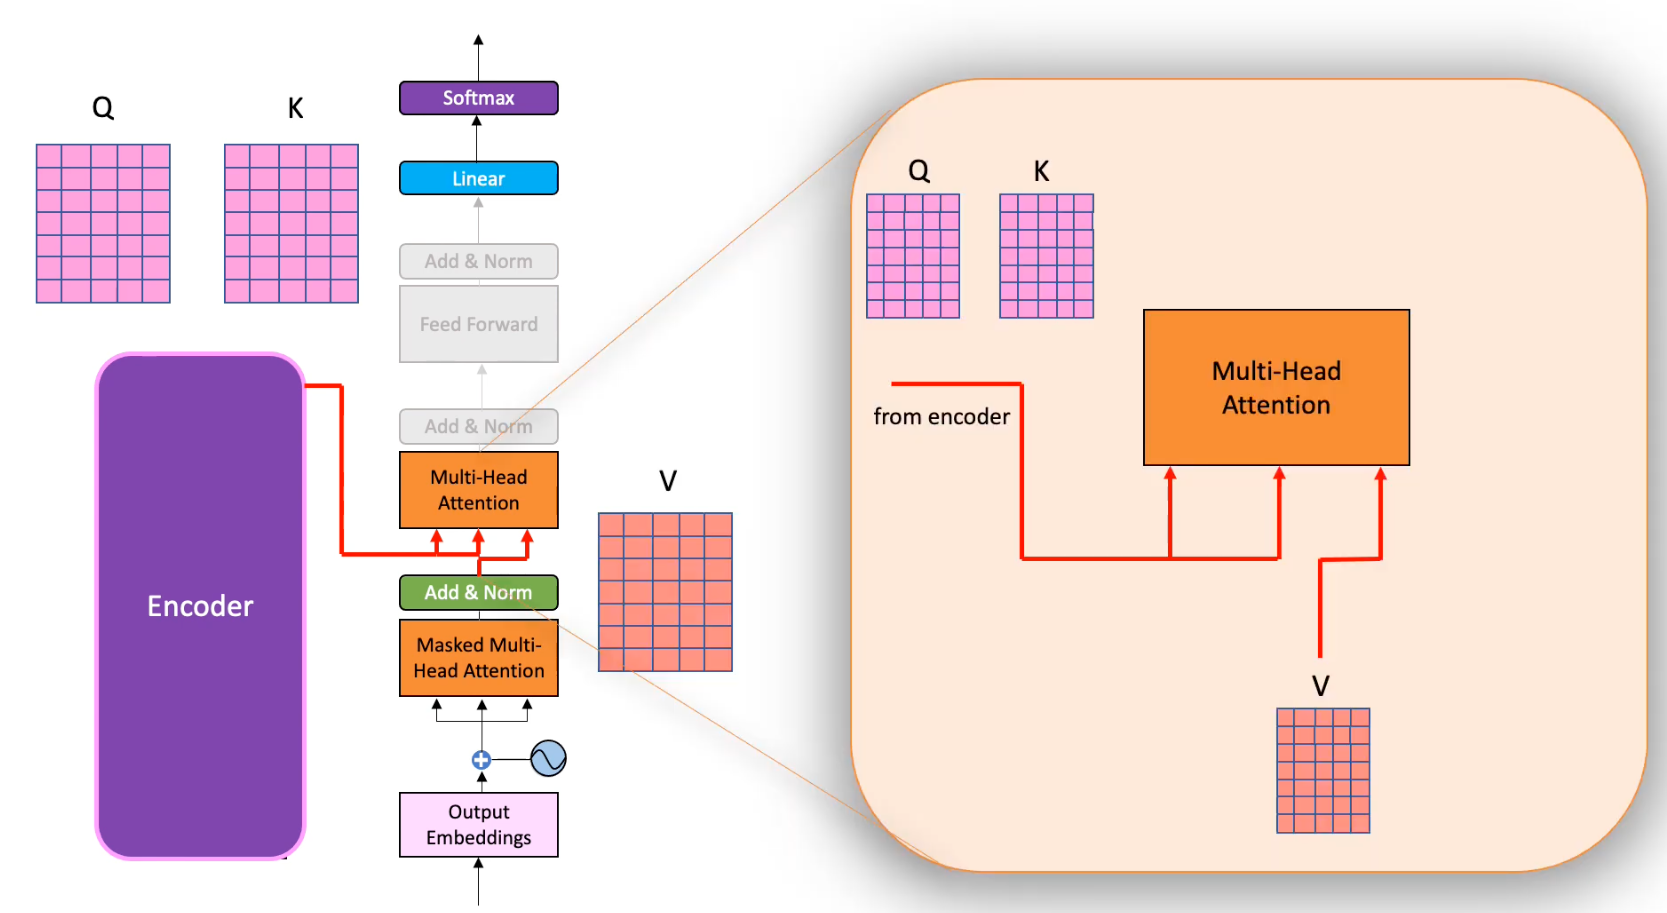

### Why masking?



In short, to avoid information leakage - as target needs to be hidden until it is needed.

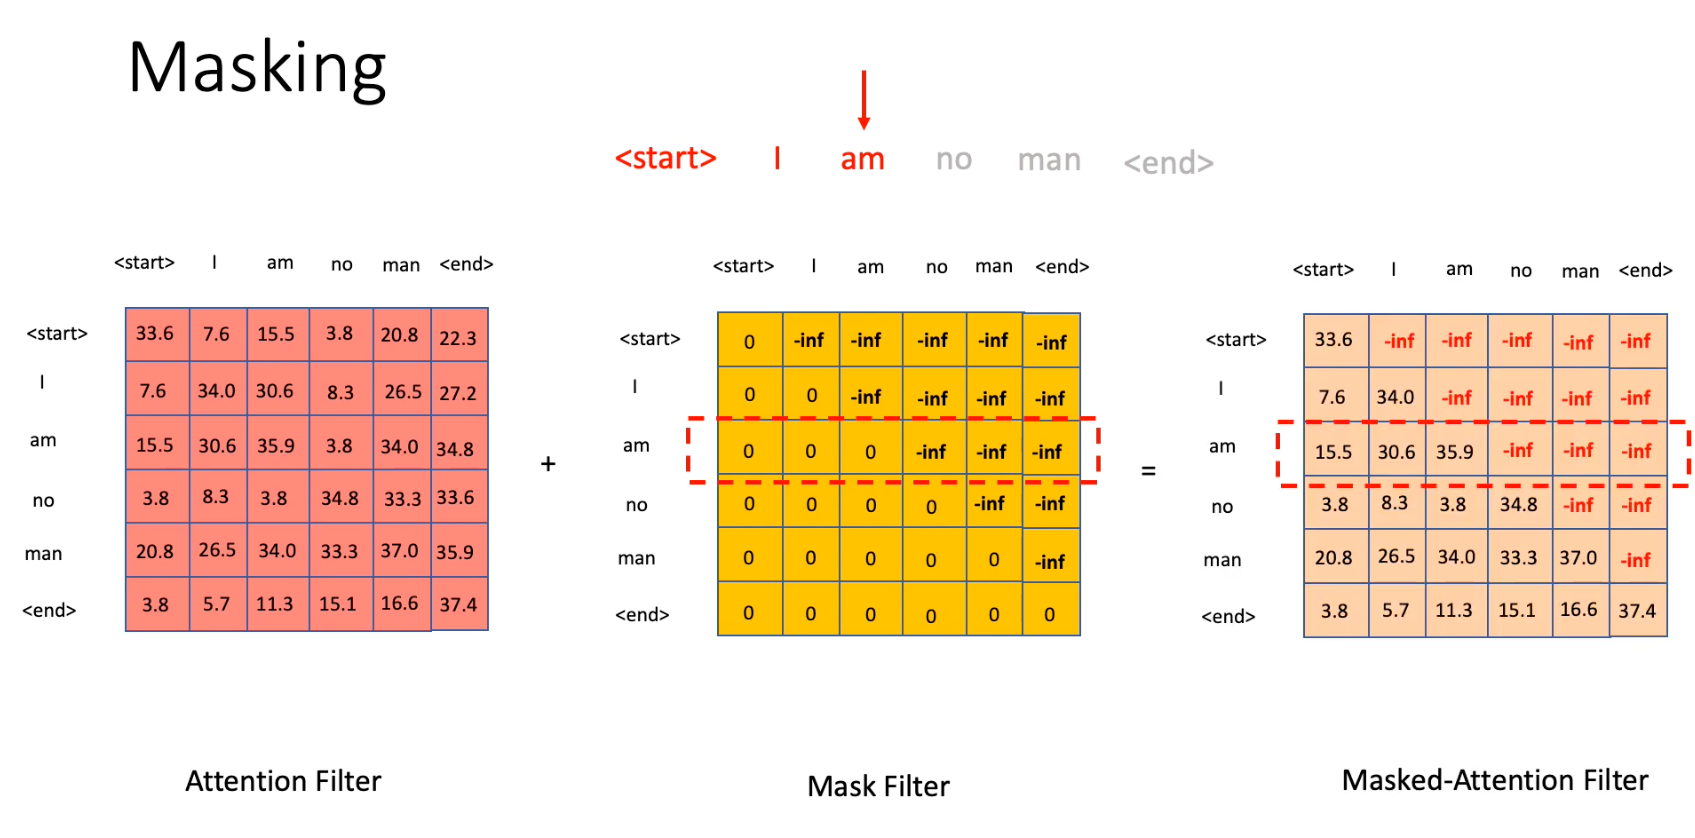

### 3.1 Scaled Dot-Product Attention (Masked)

In [ ]:
# Masking
L = 4
mask = np.tril(np.ones((L, L)))
mask

In [ ]:
class MaskedScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, d_prob):
        super(MaskedScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        self.softmax = nn.Softmax(dim=-1)
        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x_q, x_k, x_v, pad_mask):
      dot_product = torch.matmul(q, k.transpose(-1,-2))
      scaled = dot_product / math.sqrt(self.d_k)
      true_arr = torch.ones_like(scaled)
      if pad_mask != None:
        mask = torch.tril(true_arr).bool()
        scaled = scaled.masked_fill(mask==False, -1e9)
        scaled = scaled.pad_mask(pad_mask==False, -1e9)
      reg_scaled = self.softmax(scaled)
      reg_scaled = self.dropout(reg_scaled)
      attn = torch.matmul(reg_scaled, x_v)
      return attn

### 3.2 Masked Multi-Head Attention

In [ ]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, d_prob):
        super(MaskedMultiHeadAttention, self).__init__()
        self.dim_model = dim_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_head = n_head

        self.w_q = nn.Linear(dim_model, n_head * d_k)
        self.w_k = nn.Linear(dim_model, n_head * d_k)
        self.w_v = nn.Linear(dim_model, n_head * d_v)
        self.w_o = nn.Linear(n_head * d_v, dim_model)

        self.masked_scaled_dot_prod = MaskedScaledDotProductAttention(d_k, d_prob)

    def forward(self, q, k, v, pad_mask):
        # 1. Apply linear models.
        # [batch_size, seq_len, 512] -> [batch_size, att_head, seq_len, att_dim]
        x_q = self.w_q(q).view(len(q), -1, self.n_head, self.d_k).transpose(1,2)
        x_k = self.w_k(k).view(len(k), -1, self.n_head, self.d_k).transpose(1,2)
        x_v = self.w_v(v).view(len(v), -1, self.n_head, self.d_v).transpose(1,2)

        if pad_mask != None:
          pad_mask = pad_mask.unsqueeze(1)
          pad_mask = pad_mask.expand(-1, self.n_head, -1, -1)
        scaled_dot_prod_attn = self.masked_multi_head_attention(x_q, x_k, x_v, pad_mask).transpose(1,2)
        scaled_dot_prod_attn = scaled_dot_prod_attn.reshape(len(v), self.d_v * self.n_head)
        output = self.w_o(scaled_dot_prod_attn)
        return output, q

### 3.3 Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob):
        super(DecoderLayer, self).__init__()
        self.dim_model = dim_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_head = n_head
        self.dim_hidden = dim_hidden
        self.d_prob = d_prob

        self.masked_multi_head_attention = MaskedMultiHeadAttention(dim_model, d_k, d_v, n_head, d_prob)
        self.multi_head_attention = MultiHeadAttention(dim_model, d_k, d_v, n_head, d_prob)
        self.ffnn = FFNN(dim_model, dim_hidden, d_prob)

        self.layer_norm1 = nn.LayerNorm(dim_model)
        self.layer_norm2 = nn.LayerNorm(dim_model)
        self.layer_norm3 = nn.LayerNorm(dim_model)

        self.drop_out = nn.Dropout(d_prob)

    def forward(self, x, enc_output, tgt_pad_mask, src_tgt_pad_mask):
        # To be implemented
        pass

### 3.4 Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_dec_layer):
        super(Decoder, self).__init__()
        self.dim_model = dim_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_head = n_head
        self.dim_hidden = dim_hidden
        self.d_prob = d_prob
        self.n_dec_layer = n_dec_layer

        self.dec_layers = nn.ModuleList([DecoderLayer(dim_model, d_k, d_v, n_head, dim_hidden, d_prob) for _ in range(n_dec_layer)])

    def forward(self, x, enc_output, tgt_pad_mask=None, src_tgt_pad_mask=None):
        # To be implemented
        pass

## 4. Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, num_token, max_seq_len, dim_model, d_k=64, d_v=64, n_head=8, dim_hidden=2048, d_prob=0.1, n_enc_layer=6, n_dec_layer=6):
        super(Transformer, self).__init__()

        self.num_token = num_token
        self.max_seq_len = max_seq_len
        self.embed = Embedding_Layer(num_token=num_token, dim_model=dim_model, max_seq_len=max_seq_len, d_prob=d_prob)
        self.encoder = Encoder(dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_enc_layer)
        self.decoder = Decoder(dim_model, d_k, d_v, n_head, dim_hidden, d_prob, n_dec_layer)
        self.linear = nn.Linear(dim_model, num_token)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src, tgt):
        positional_encoded_src = self.embed(src)
        src_pad_mask = self.make_mask(src)
        enc_output = self.encoder(positional_encoded_src, src_pad_mask.bool())

        positional_encoded_tgt = self.embed(tgt)
        tgt_pad_mask = self.make_mask(tgt)
        tgt_src_pad_mask = torch.bmm(tgt_pad_mask, src_pad_mask.transpose(-1,-2))

        dec_output = self.decoder(positional_encoded_tgt, enc_output, tgt_pad_mask.bool(), tgt_src_pad_mask.bool())
        outputs = self.linear(dec_output)
        outputs = self.softmax(outputs)
        return outputs

    def make_mask(self, x):
        pad_mask = torch.where(x==2, 0., 1.)
        pad_mask = pad_mask.unsqueeze(-1)
        pad_mask = torch.bmm(pad_mask, pad_mask.transpose(-1, -2))
        return pad_mask

### Training Transformer

In [ ]:
def train(dataloader, epochs, model, criterion, vocab, i2w):
	model.train()
	model.zero_grad()
	optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2), eps=eps)
	correct = 0

	cnt = 0
	total_score = 0.
	global_step = 0
	tr_loss = 0.
	for epoch in range(epochs):

		for idx, (src, tgt) in enumerate(dataloader):
			src, tgt = src.to(device), tgt.to(device)
			optimizer.zero_grad()

			outputs = model(src, tgt[:, :-1])
			tgt = tgt[:, 1:]

			tgt = torch.flatten(tgt)
			outputs = outputs.reshape(len(tgt), -1)
			loss = criterion(outputs, tgt)
			tr_loss += loss.item()

			loss.backward()
			torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
			optimizer.step()
			global_step += 1

			pred = outputs.argmax(dim=1, keepdim=True)
			pred_acc = pred[tgt != 2]
			tgt_acc = tgt[tgt != 2]

			correct += pred_acc.eq(tgt_acc.view_as(pred_acc)).sum().item()

			cnt += tgt_acc.shape[0]
			score = 0.

			with torch.no_grad():
				pred = pred.reshape(batch_size, max_len, -1).detach().cpu().tolist()
				tgt = tgt.reshape(batch_size, max_len).detach().cpu().tolist()
				for p, t in zip(pred, tgt):
					eos_idx = t.index(vocab['[PAD]']) if vocab['[PAD]'] in t else len(t)
					p_seq = [i2w[i[0]] for i in p][:eos_idx]
					t_seq = [i2w[i] for i in t][:eos_idx]
					k = 4 if len(t_seq) > 4 else len(t_seq)
					s = utils.bleu_score(p_seq, t_seq, k=k)
					score += s
					total_score += s

			score /= batch_size

			print("\r[epoch {:3d}/{:3d}] [batch {:4d}/{:4d}] loss: {:.6f} acc: {:.4f} BLEU: {:.4f})".format(
				epoch, n_epochs, idx + 1, len(dataloader), loss, correct / cnt, score), end=' ')

	tr_loss /= cnt
	tr_acc = correct / cnt
	tr_score = total_score / len(dataloader.dataset) / epochs

	return tr_loss, tr_acc, tr_score

def eval(dataloader, model, lengths=None):
    # Implement this
    pass

In [ ]:
utils.set_random_seed(42)
trn_dataset = dataloader.MiniWMT15_en_ru_Dataset(max_len=20, src_filepath='../data/src_train.txt', tgt_filepath='../data/tgt_train.txt', vocab=(None, None), is_src=True, is_tgt=False, is_train=True)
test_dataset = dataloader.MiniWMT15_en_ru_Dataset(max_len=20, src_filepath='../data/src_test.txt', tgt_filepath=None, vocab=(trn_dataset.vocab, None), is_src=True, is_tgt=False, is_train=False)
vocab = trn_dataset.vocab
i2w = {v: k for k, v in vocab.items()}
trn_dataloader = DataLoader(trn_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
n_token = len(trn_dataset.vocab)
model = Transformer(num_token=n_token, max_seq_len=max_len, dim_model=model_dim, d_k=d_k, d_v=d_v, n_head=n_head, dim_hidden=hidden_size, d_prob=d_prob, n_enc_layer=num_enc_layers, n_dec_layer=num_dec_layers)
model = model.to(device)
criterion = nn.NLLLoss(ignore_index=vocab['[PAD]'])

tr_loss, tr_acc, tr_score = train(trn_dataloader, n_epochs, model, criterion, vocab, i2w)
print("tr: ({:.4f}, {:5.2f}, {:5.2f}) | ".format(tr_loss, tr_acc * 100, tr_score * 100), end='')
